# Assignment 4: Cheminformatics

Cheminformatics is at the interface of chemistry, computer science, and data science. It encompasses the use of computer algorithms and their application to chemistry problems. One important use case of cheminformatics is the implementation of and interaction with chemistry databases such as [PubChem](https://pubchem.ncbi.nlm.nih.gov/). In this assigment, we will work with database queries using SMARTS via the dedicated cheminformatics python package [rdkit](https://www.rdkit.org/docs/GettingStartedInPython.html). If you want to practice more with SMILES before working on this notebook, I recommend you to look at this [SMILES Tutorial](https://colab.research.google.com/github/PatWalters/practical_cheminformatics_tutorials/blob/main/fundamentals/SMILES_tutorial.ipynb).

This assignment was taken from the following repository before being adapted for this lecture:

https://github.com/PatWalters/practical_cheminformatics_tutorials

Let us start with installing the rdkit package.

In [1]:
# install rdkit via pip
!pip install rdkit

# ! indicates that the command should be executed as a shell command rather than a python statement
# pip is a package manager for python
# rdkit is a collection of cheminformatics and machine learning tools designed to handle chemical structures, substructures, and chemical data.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 14.5 MB/s eta 0:00:00


Now, let us load all the packages we will need for this exercise and change some settings that will make sure that molecules are depicted in a nice way.

In [2]:
# import required packages
from rdkit.Chem.Draw import IPythonConsole                              # this module provides utilities for displaying chemical structures
from rdkit.Chem import rdDepictor                                       # this module is responsible for 2D depiction of chemical structures
from rdkit import Chem                                                  # this module provides various functionalities related to handling chemical structures, such as reading, writing and manipulating molecular structures
import pandas as pd

# change display settings in the jupyter notebook and in rdkit
IPythonConsole.ipython_useSVG = True                                    # sets an option to use Scalable Vector Graphics(SVG) format for rendering chemical structures
IPythonConsole.molSize = 300, 300                                       # sets default size for displaying molecular structures
rdDepictor.SetPreferCoordGen(True)                                      # configures rdkit to use coordinate generation when depicting molecules. This helps in positioning atoms in 2D space for visualization purpose

### Introduction

The **SM**ILES **AR**bitrary **T**arget **S**pecification (SMARTS) is a language for pattern matching in molecules.  SMARTS provides concise means of matching specific substructures in molecules.  Like SMILES, SMARTS was developed and refined by [David Weininger](https://en.wikipedia.org/wiki/David_Weininger) and colleagues at Daylight Chemical Information Systems.  

The canonical reference for SMARTS is the [Daylight Theory Manual](https://www.daylight.com/dayhtml/doc/theory/), I have borrowed liberally from that here. The [Daylight SMARTS Tutorial](https://www.daylight.com/dayhtml_tutorials/languages/smarts/index.html) is another essential reference.

SMARTS share a lot of the same syntax as SMILES but there are a number of critical differences.  At a simple level, any SMILES is also a valid SMARTS.  However, a query with that SMARTS may not give you the answer you want.  This can best be explained via an example.  

In the RDKit, we can parse a SMARTS and create a molecule with pattern matching abilities using the function **Chem.MolFromSmarts**.  If we look at the depicted structure below, we can see that there are aromatic bonds between the ring atoms.  These bond types are implicit since no bonds were specified.  The bond to the methyl carbon is also not specified, so it is of type **single or aromatic**.

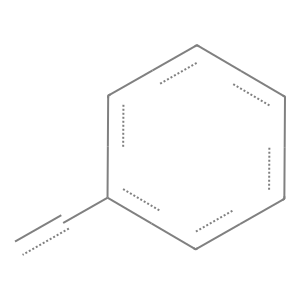

In [3]:
query_mol = Chem.MolFromSmarts("c1ccccc1C")        # query molecule from SMARTS
query_mol

Now, let us create a molecule that we'll match.  As a first example, we will use ethylbenzene. Since this is a molecule, not a query for searching, we will use **Chem.MolFromSmiles**.

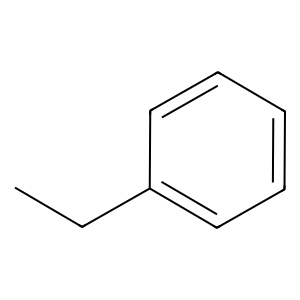

In [4]:
ethyl_benzene = Chem.MolFromSmiles("c1ccccc1CC")    # Molecule from SMILES

ethyl_benzene

We can now see if our query matches ethyl benzene by using the **HasSubstructMatch** method of the ethyl_benzene molecule object.

In [5]:
ethyl_benzene.HasSubstructMatch(query_mol)         # Checking whether the molecule contains a substructure that matches the SMARTS pattern

True

The value **True** above indicates that the ethyl_benzene molecule object does indeed contain the substructure specified by query_mol. We can use the function **GetSubstructMatch** to identify the specific atoms matching a pattern. The code below shows that the pattern specified by query_mol matches atoms 0,1,2,3,4,5 and 6.  

In [6]:
ethyl_benzene.GetSubstructMatch(query_mol)         # finding the substructure of the molecule that matches the query and returning a tuple of indices of the atoms in the molecule that matches

(0, 1, 2, 3, 4, 5, 6)

One interesting side effect of the call to GetSubstructMatch above is that the depiction shows the selected atoms as highlighted.

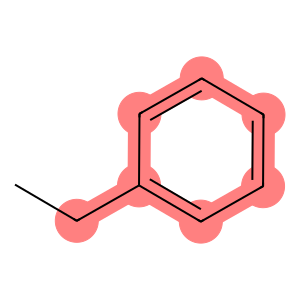

In [7]:
ethyl_benzene                                     # highlighting the matching atoms

### Properties of Atoms

So far so good, now let us create another molecule and look at how our pattern matches. This time we will use biphenyl.

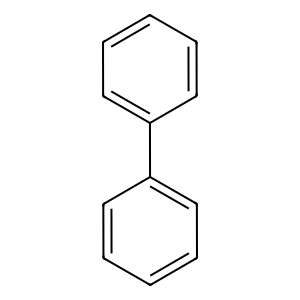

In [8]:
biphenyl = Chem.MolFromSmiles("c1ccccc1c1ccccc1")
biphenyl

In [9]:
biphenyl.HasSubstructMatch(query_mol)

False

You should have seen that the query did not match. Did you observe that as well? Why did the query not match?  It is because the query SMARTS c1ccccc1**C** specified a phenyl ring connected to an **aliphatic** carbon.  In biphenyl the corresponding carbon atom is aromatic. In SMARTS, "C" only matches aliphatic carbon atoms and "c" only matches aromatic carbon atoms.  If we wish to match any carbon we can use "[#6]" to specify the atom.  

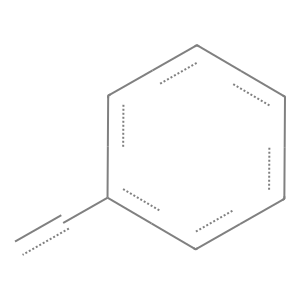

In [10]:
new_query_mol = Chem.MolFromSmarts("c1ccccc1[#6]")
new_query_mol

In [11]:
biphenyl.HasSubstructMatch(new_query_mol)

True

In [12]:
biphenyl.GetSubstructMatch(new_query_mol)

(0, 1, 2, 3, 4, 5, 6)

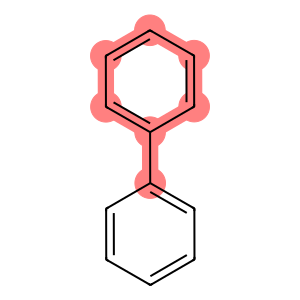

In [13]:
biphenyl

A similar approach can be applied with other atom types, we can specify any nitrogen atom as [#7] or any oxygen atom as [#8].   

SMARTS can also be used to query for atoms with a particular charge.  For instance, the SMARTS **[-1]** can be used to identify molecules with a charge of -1.  Note that searching with a SMARTS this way will only identify molecules that were input with a charge of -1.  SMARTS searching does not attempt to determine a molecule's ionization state.  In the example below, we match the SMARTS [-1] against neutral and charged versions of acetic acid.

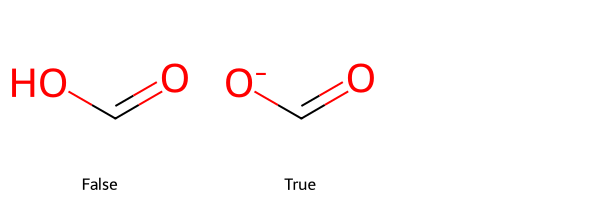

In [14]:
# A list of SMILES with formic acid and formate anion
smiles_list = ["C(=O)O","C(=O)[O-]"]
# Convert SMILES to RDKit molecules
mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
# Create a query molecule from SMARTS
anion_query = Chem.MolFromSmarts("[-1]")
# Match the query to the molecules, convert the output to string so that MolsToGrid can display as a legend
match_list = [str(x.HasSubstructMatch(anion_query)) for x in mol_list]
# Draw the structures
Chem.Draw.MolsToGridImage(mol_list,legends=match_list)

### Queries With Atom Lists

In many cases, we want to be able to create a query that will match multiple atom types.  For instance, we may want to create a query that will match both benzene and pyridine.  We can do this by specifying a comma-separated list of atom types in square brackets.  We can specify a query that will match benzene and pyridine with the SMARTS **c1cccc[c,n]1**.

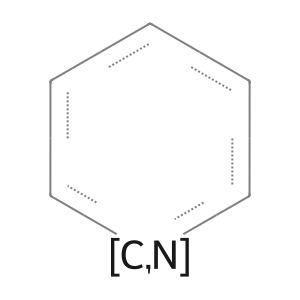

In [15]:
ben_pyr = Chem.MolFromSmarts("c1cccc[c,n]1")
ben_pyr

In [16]:
benzene = Chem.MolFromSmiles("c1ccccc1")
pyridine = Chem.MolFromSmiles("c1cccnc1")

In [17]:
benzene.HasSubstructMatch(ben_pyr)

True

In [18]:
pyridine.HasSubstructMatch(ben_pyr)

True

Note that we could also rewrite the query we used above to match aromatic and aliphatic carbon atoms as **c1cccc[c,C]1**.

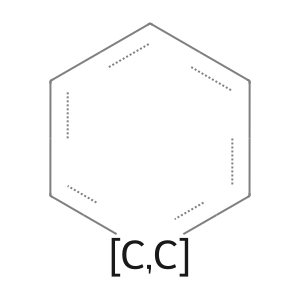

In [19]:
ali_aro = Chem.MolFromSmarts("c1cccc[c,C]1")
ali_aro

In [20]:
benzene.HasSubstructMatch(ali_aro)

True

Atom lists can also include atom specifiers such as [#8].  We can construct a query that matches any nitrogen or oxygen attached to an aliphatic carbon as **C[#7,#8]**. Test this with the following provided molecule.

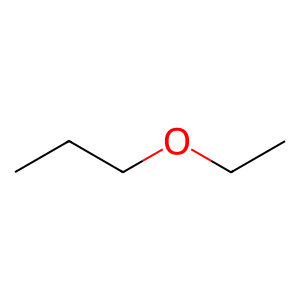

In [21]:
mol = Chem.MolFromSmiles("CCCOCC")
mol

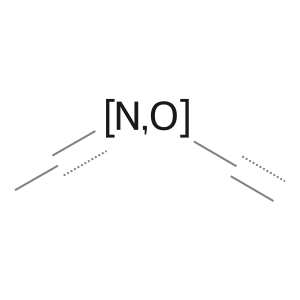

In [22]:
query_mol2 = Chem.MolFromSmarts("C[#7,#8]C")
query_mol2

In [23]:
mol.HasSubstructMatch(query_mol2)

True

### SMARTS Specifying the Number of Attachments to an Atom

There are two ways of writing queries that specify the number of attachments to an atom.  Valence, which is specified with "v" and degree which is specified with "D".  In order to test the two types of queries, let us define a few molecules.

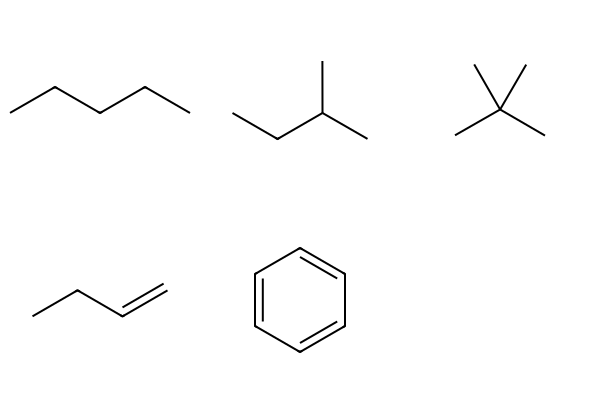

In [24]:
smiles_list = ["CCCCC","CC(C)CC","CC(C)(C)C","C=CCC","c1ccccc1"]
mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
Chem.Draw.MolsToGridImage(mol_list)

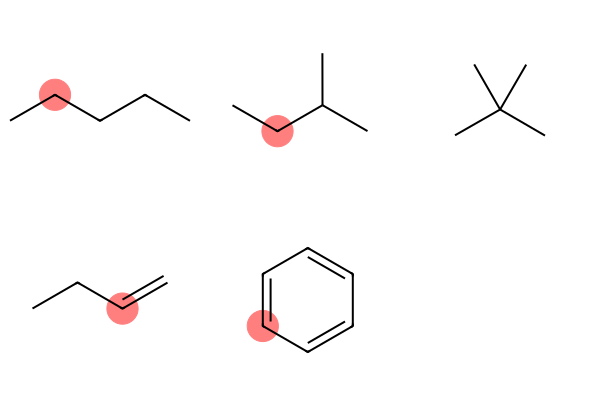

In [25]:
query_smarts = "[D2]"      # secondary carbon
query_mol = Chem.MolFromSmarts(query_smarts)
match_list = []
for mol in mol_list:
    match_list.append(mol.GetSubstructMatch(query_mol))
Chem.Draw.MolsToGridImage(mol_list,highlightAtomLists=match_list)

In [26]:
mol_list[0].GetSubstructMatches(query_mol)

((1,), (2,), (3,))

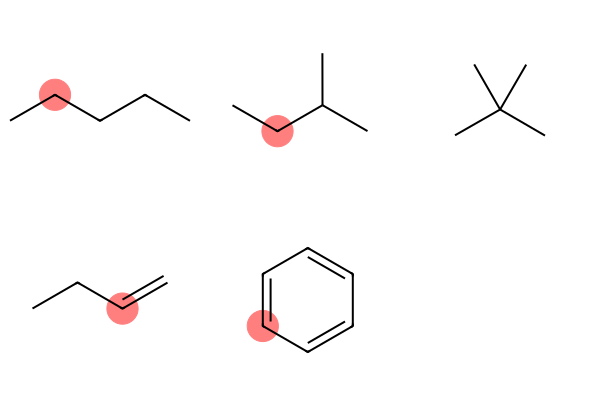

In [27]:
Chem.Draw.MolsToGridImage(mol_list,highlightAtomLists=match_list)

Try a few queries on the smiles list defined above:
- aliphatic carbon - C
- aromatic carbon - c
- vinyl group C=C
- trisubstituted carbon [#6D3]
- carbon with three attached bonds [#6X3]

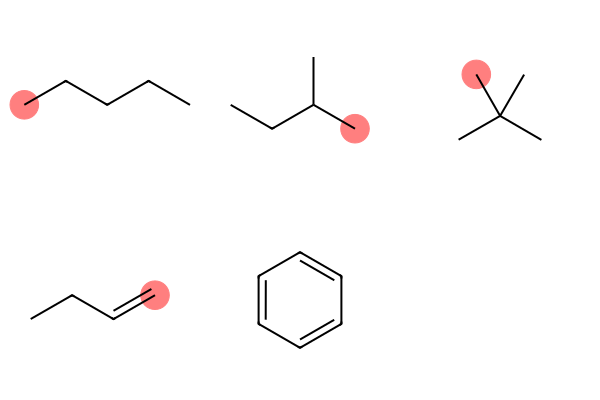

In [28]:
# ALIPHATIC CARBON
query_smarts = "[C]"
query_mol = Chem.MolFromSmarts(query_smarts)
match_list = []
for mol in mol_list:
    match_list.append(mol.GetSubstructMatch(query_mol))
Chem.Draw.MolsToGridImage(mol_list,highlightAtomLists=match_list)

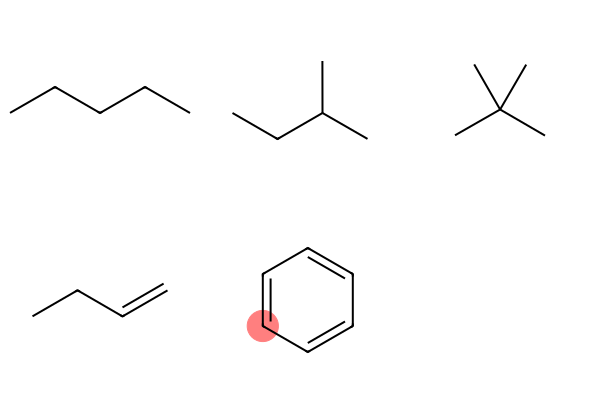

In [29]:
# AROMATIC CARBON
query_smarts = "[c]"
query_mol = Chem.MolFromSmarts(query_smarts)
match_list = []
for mol in mol_list:
    match_list.append(mol.GetSubstructMatch(query_mol))
Chem.Draw.MolsToGridImage(mol_list,highlightAtomLists=match_list)

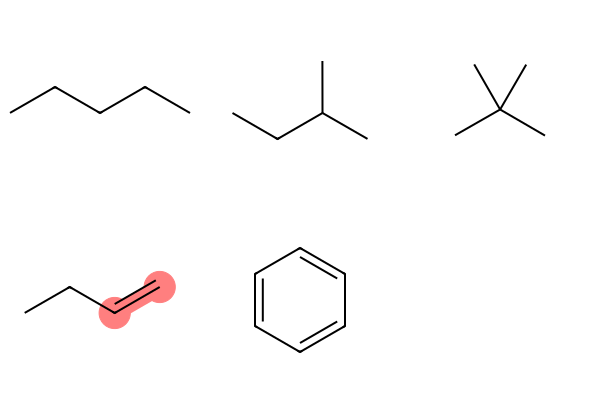

In [30]:
# VINYL GROUP
query_smarts = "[#6]=[#6]"
query_mol = Chem.MolFromSmarts(query_smarts)
match_list = []
for mol in mol_list:
    match_list.append(mol.GetSubstructMatch(query_mol))
Chem.Draw.MolsToGridImage(mol_list,highlightAtomLists=match_list)

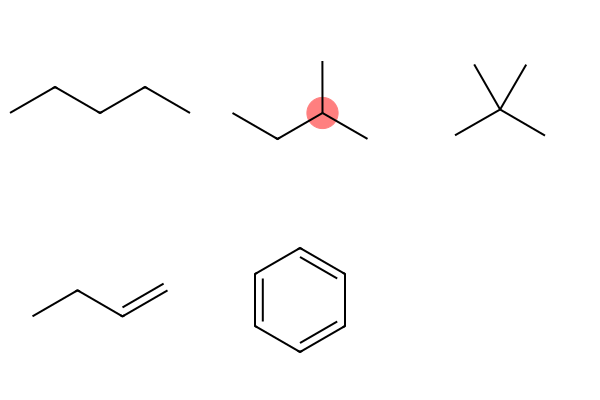

In [31]:
# TRISUBSTITUTED CARBON
query_smarts = "[#6D3]"
query_mol = Chem.MolFromSmarts(query_smarts)
match_list = []
for mol in mol_list:
    match_list.append(mol.GetSubstructMatch(query_mol))
Chem.Draw.MolsToGridImage(mol_list,highlightAtomLists=match_list)

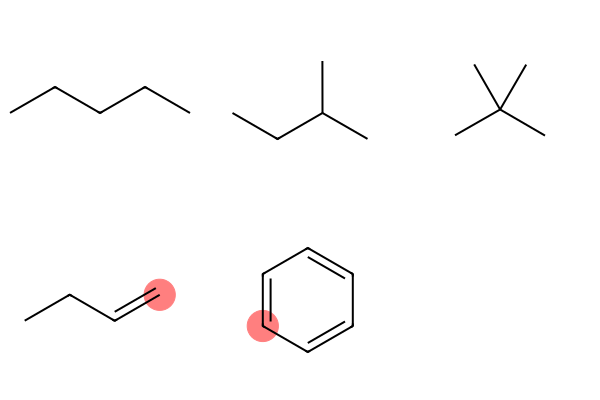

In [32]:
# CARBON WITH THREE ATTACHED BONDS
query_smarts = "[#6X3]"
query_mol = Chem.MolFromSmarts(query_smarts)
match_list = []
for mol in mol_list:
    match_list.append(mol.GetSubstructMatch(query_mol))
Chem.Draw.MolsToGridImage(mol_list,highlightAtomLists=match_list)

## Database Queries
SMARTS is particularly useful for making database queries. You can find all molecules in a large set of structures that contain a particular substructure. The following code cell downloads a small set of molecules from a GitHub repository via the pandas package and creates a list from the corresponding SMILES strings.

In [33]:
df = pd.read_csv("https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/data/smarts_test.smi",sep=" ",names=["SMILES","Name"])
small_database = list(df['SMILES'].values)

Based on this list of SMILES strings, the following two subsections ask you to make several database queries. For all the queries mentioned, visualize all the matching molecules in a grid and highlight the atoms in the molecules that match the pattern. For each of the queries, also print the number of matches.

### Additional Atom Primitives
Use the grid below as a reference for some other SMARTS atom primitives.  The table below was taken from [The RDKit Book](https://www.rdkit.org/docs/RDKit_Book.html)
<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/images/smarts_atom_primitives.png" width="800"/>

See if you can find the following in the small database:
- All the molecules with a four membered ring
- All the carboxylic acids
- All the atoms contained in 2 rings

In [34]:
# define a function for finding the matching molecules
def find_matching_molecules(smiles_list, smarts_pattern):
    matching_molecules = []                                                      # an empty list to store the smiles of molecules that match
    query = Chem.MolFromSmarts(smarts_pattern)                                   # converts smarts pattern into a query molecule
    for smiles in smiles_list:                                                   # starts a loop that iterates through each smile in the smiles_list
        mol = Chem.MolFromSmiles(smiles)                                         # converts each smile into a molecule
        if mol.HasSubstructMatch(query):                                         # checks for the match between mol ad query
           matching_molecules.append(smiles)                                     # adds the macthing molecule into the list
    return matching_molecules

The number of matches is 3


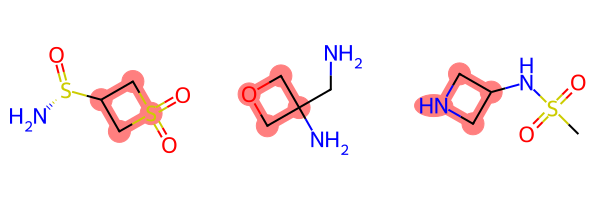

In [35]:
# All the molecules with a four membered ring

# defining the parameters of the function
smiles_list = small_database
query_smarts = "[*]1[*][*][*]1"
matching_molecules = find_matching_molecules(smiles_list, query_smarts)

# printing the number of matches
x = len(matching_molecules)
print(f"The number of matches is {x}")

#to highlight the matching atoms
mole_list = [Chem.MolFromSmiles(smiles) for smiles in matching_molecules]        # a list containing molecules converted from the smiles in the matching molecules
query_mol = Chem.MolFromSmarts(query_smarts)                                     # converts the query_smarts into a molecule
match_list= []                                                                   # an empty list to store the atom indices of the match
for mol in mole_list:                                                            # iterates over molecules in the mole list
  match_list.append(mol.GetSubstructMatch(query_mol))                            # find the atom indices of the substructure matches and adds to the list

Chem.Draw.MolsToGridImage(mole_list,highlightAtomLists=match_list)               # visualizes the mole list and highlights the substructure matches in the match list

The number of matches is 16


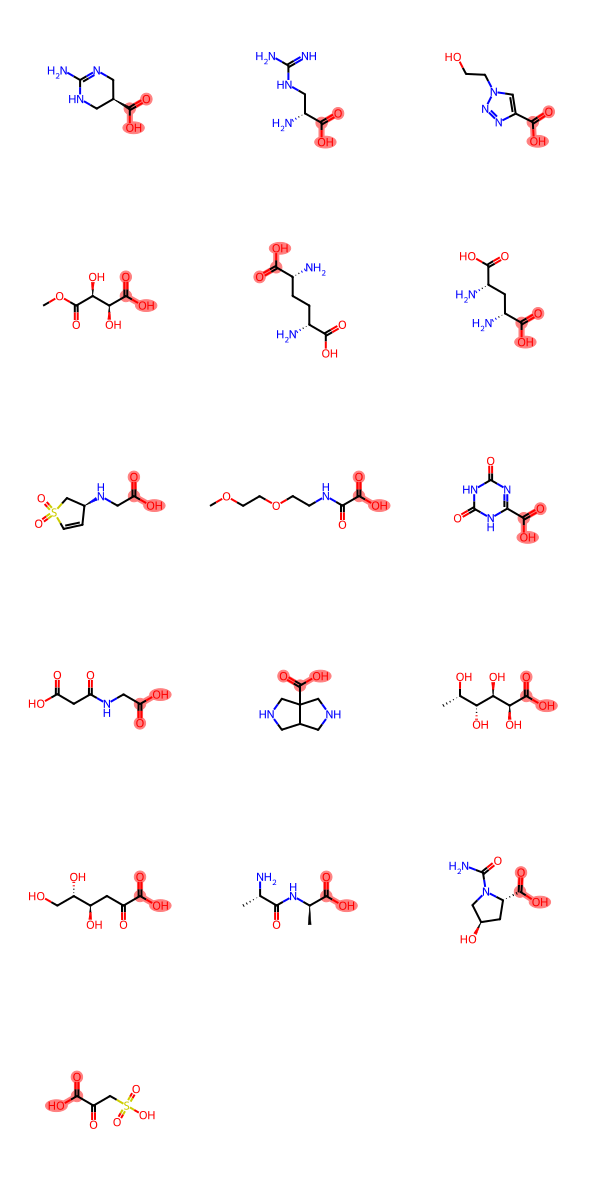

In [36]:
# All the carboxylic acid
smiles_list = small_database
query_smarts = "C(=O)[OH]"
matching_molecules = find_matching_molecules(smiles_list, query_smarts)
x = len(matching_molecules)
print(f"The number of matches is {x}")

mole_list = [Chem.MolFromSmiles(smiles) for smiles in matching_molecules]
query_mol = Chem.MolFromSmarts(query_smarts)
match_list= []
for mol in mole_list:
  match_list.append(mol.GetSubstructMatch(query_mol))

Chem.Draw.MolsToGridImage(mole_list,highlightAtomLists=match_list)

The number of matches is 15


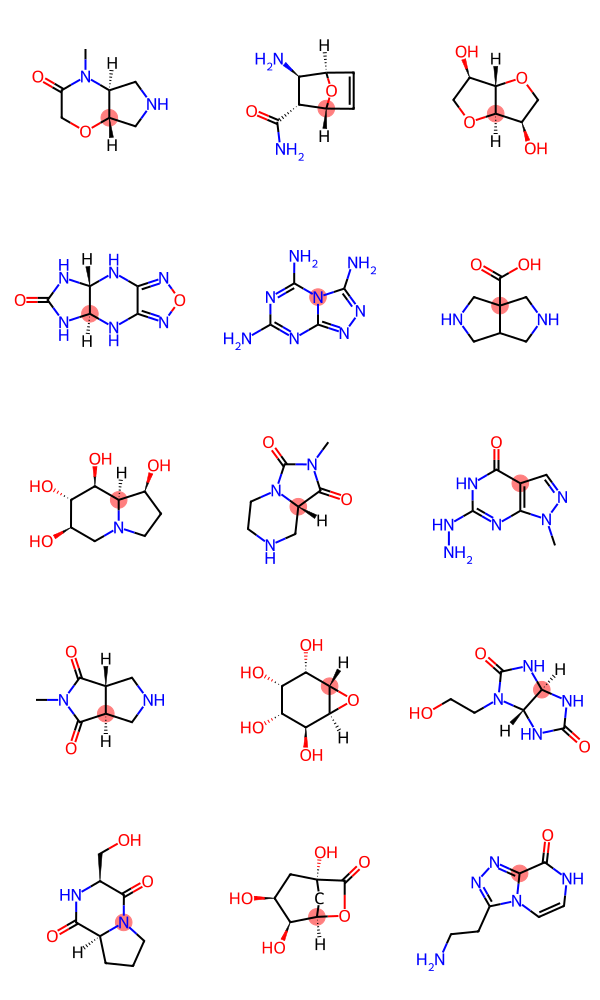

In [37]:
# All the atoms contained in two rings
smiles_list = small_database
query_smarts = "[R2]"
matching_molecules = find_matching_molecules(smiles_list, query_smarts)
x = len(matching_molecules)
print(f"The number of matches is {x}")

mole_list = [Chem.MolFromSmiles(smiles) for smiles in matching_molecules]
query_mol = Chem.MolFromSmarts(query_smarts)
match_list= []
for mol in mole_list:
  match_list.append(mol.GetSubstructMatch(query_mol))

Chem.Draw.MolsToGridImage(mole_list,highlightAtomLists=match_list)

### Bond Primitives
Use the grid below as a reference for some SMARTS bond primitives.  The table below was taken from [The RDKit Book](https://www.rdkit.org/docs/RDKit_Book.html)
<img src="https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/images/smarts_bond_primitives.png" width="500"/>


See if you can find the following in the small database:
- Sulfur connected by any ring bond to carbon
- A double bond in a ring
- Any atom triple bonded to any other atom

The number of matches is 3


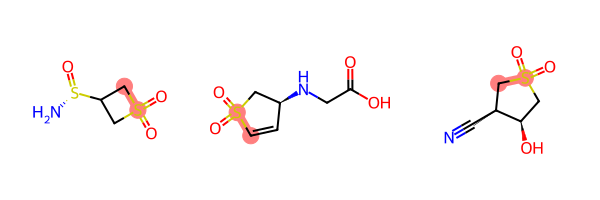

In [38]:
# Sulfur connected by any ring bond to carbon
smiles_list = small_database
query_smarts = "S@[#6]"
matching_molecules = find_matching_molecules(smiles_list, query_smarts)
x = len(matching_molecules)
print(f"The number of matches is {x}")

mole_list = [Chem.MolFromSmiles(smiles) for smiles in matching_molecules]
query_mol = Chem.MolFromSmarts(query_smarts)
match_list= []
for mol in mole_list:
  match_list.append(mol.GetSubstructMatch(query_mol))

Chem.Draw.MolsToGridImage(mole_list,highlightAtomLists=match_list)

The number of matches is 8


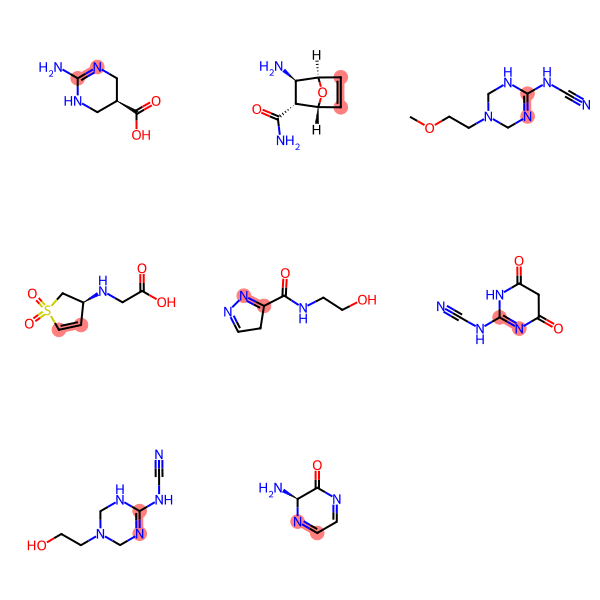

In [39]:
# A double bond in the ring
smiles_list = small_database
query_smarts = "[*]@=[*]"
matching_molecules = find_matching_molecules(smiles_list, query_smarts)
x = len(matching_molecules)
print(f"The number of matches is {x}")

mole_list = [Chem.MolFromSmiles(smiles) for smiles in matching_molecules]
query_mol = Chem.MolFromSmarts(query_smarts)
match_list= []
for mol in mole_list:
  match_list.append(mol.GetSubstructMatch(query_mol))

Chem.Draw.MolsToGridImage(mole_list,highlightAtomLists=match_list)

The number of matches is 10


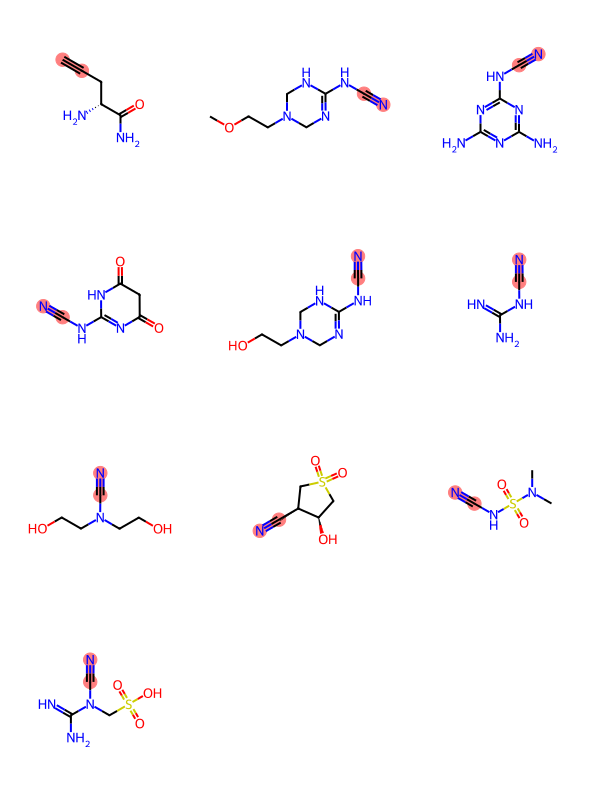

In [40]:
# Any atom triple bonded to another atom
smiles_list = small_database
query_smarts = "[*]#[*]"
matching_molecules = find_matching_molecules(smiles_list, query_smarts)
x = len(matching_molecules)
print(f"The number of matches is {x}")

mole_list = [Chem.MolFromSmiles(smiles) for smiles in matching_molecules]
query_mol = Chem.MolFromSmarts(query_smarts)
match_list= []
for mol in mole_list:
  match_list.append(mol.GetSubstructMatch(query_mol))

Chem.Draw.MolsToGridImage(mole_list,highlightAtomLists=match_list)